In [6]:
import pandas as pd
import geopandas as gpd
import os
import json

In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib

medium_font = fm.FontProperties(fname =  "D:/bachelors/datasets/viz/Roboto-Medium.ttf", size = 12)
regluar_font = fm.FontProperties(fname = "D:/bachelors/datasets/viz/Roboto-Regular.ttf", size = 12)

colors = {
    'peach' : '#FCB886',
    'blue' : '#6FC7F7',
    'green' : '#78AF34',
    'red' : '#D25B5B',
    'grey' : '#8B8B8B'
}

In [8]:
os.chdir('D:/bachelors/datasets/')

In [9]:
year = 2004

In [10]:
from functools import reduce
from numpy import mean

In [18]:
df = reduce(lambda left, right: pd.merge(left, right, on = ['geo_departure', 'geo_arrival'], how = 'outer'), [
    pd.read_csv(f'translated_data_v4/data_{year}.csv').groupby(['geo_departure', 'geo_arrival'])['uid_person'].nunique().reset_index() for year in range(2004,2018)
])
df = df.set_index(['geo_departure', 'geo_arrival']).mean(axis = 1).unstack('geo_arrival')

df = df.apply(lambda row: row / row.sum() * 100, axis = 1).stack().rename('rides_share').reset_index()
df = df[df.geo_departure == df.geo_arrival]

In [42]:
communes = gpd.read_file('../qgis/base/Netherlands_communes.gpkg')

In [48]:
internal_rides_by_commune = communes.merge(
    df.drop(columns = 'geo_arrival').rename(columns = {'geo_departure' : 'NAME'}),
    on = 'NAME', how = 'left'
)

In [77]:
communes_to_provinces = pd.read_excel(r"D:\bachelors\datasets\Сommunes to Provices.xlsx").set_index('commune')
communes_to_provinces.loc["'s-Hertogenbosch"] = 'North Brabant'
communes_to_provinces = communes_to_provinces['province'].to_dict()

In [78]:
communes['province'] = communes['NAME'].map(communes_to_provinces)

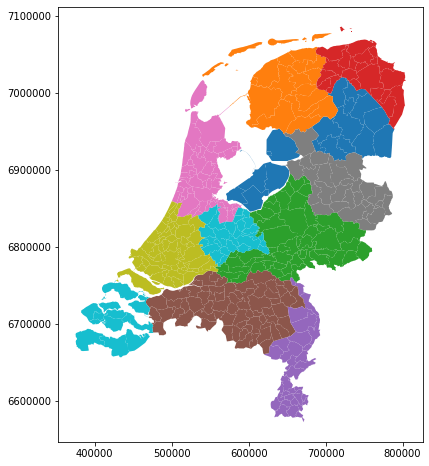

In [79]:
communes.to_crs({'init' : 'epsg:3857'}).plot(column = 'province', figsize = (10,8))

In [82]:
provinces = communes.dissolve(by = 'province').reset_index()

In [84]:
df = reduce(lambda left, right: pd.merge(left, right, on = ['geo_departure', 'geo_arrival'], how = 'outer'), [
    pd.read_csv(f'translated_data_v4/data_{year}.csv').assign(
        geo_departure = lambda frame: frame.geo_departure.map(communes_to_provinces),
        geo_arrival = lambda frame: frame.geo_arrival.map(communes_to_provinces)
    ).groupby(['geo_departure', 'geo_arrival'])['uid_person'].nunique().reset_index() for year in range(2004,2018)
])
df = df.set_index(['geo_departure', 'geo_arrival']).mean(axis = 1).unstack('geo_arrival')

df = df.apply(lambda row: row / row.sum() * 100, axis = 1).stack().rename('rides_share').reset_index()
df = df[df.geo_departure == df.geo_arrival]

In [92]:
df['province_rus'] = pd.Series(['Дренте', 'Флеволанд', 'Фрисландия', 'Гелдерланд',
                                'Гронинген', 'Лимбург', 'Северный Брабант', 'Северная Голландия',
                                'Оверэйссел', 'Южная Голландия', 'Утрехт', 'Зеландия'])

In [91]:
df = df.reset_index().drop(columns = 'index')

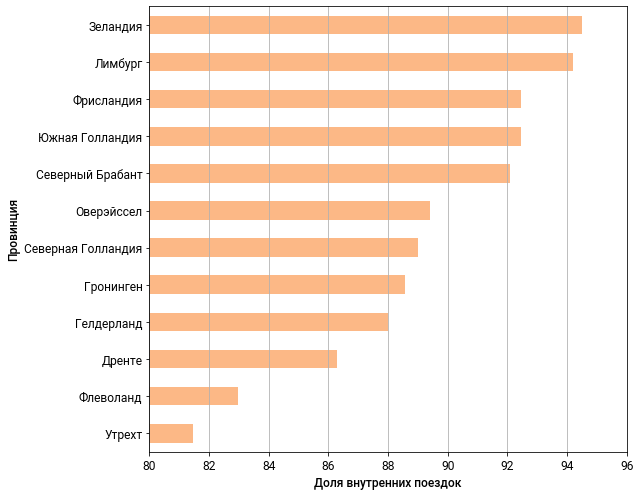

In [198]:
df.set_index('province_rus')['rides_share'].sort_values().plot.barh(color = colors['peach'], figsize = (9,7))
plt.xlim(80,96)
plt.grid(axis = 'x', which = 'both')
plt.xticks(font_properties = regluar_font)
plt.xlabel('Доля внутренних поездок', font_properties = medium_font)
plt.yticks(font_properties = regluar_font)
plt.ylabel('Провинция', font_properties = medium_font)
plt.tight_layout()
plt.savefig('analysis/internal_rides/Internal_rides by Province.png', dpi = 192)

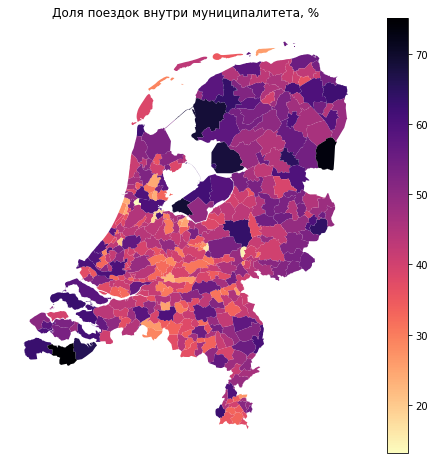

In [125]:
internal_rides_by_commune.to_crs({'init' : 'epsg:3857'}).plot(column = 'rides_share', figsize = (8,8),
                                                              legend = True, cmap = 'magma_r')
plt.axis('off')
plt.title('Доля поездок внутри муниципалитета, %')
plt.savefig('analysis/internal_rides/Internal_rides by Municipality.png',  dpi = 192)

In [231]:
internal_rides_by_commune.to_file('analysis/internal_rides/Internal_Rides.gpkg', driver = 'GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_Internal_Rides_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_Internal_Rides_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
